In [1]:
import os
from os import path
import numpy as np
from detectree import pixel_features
import joblib
import rasterio
from rasterio import plot
import scipy.ndimage
from pathlib import Path
import skimage.morphology
import maxflow as mf
import pandas as pd
import inspect
from urbantree.setting import Setting

In [3]:
SETTING = "settings/opendata_luftbild_dop60_1312/detectree_r1/setting.yaml"
#SETTING = "settings/opendata_luftbild_dop60_1312/detectree_r1/setting.yaml"

SETTING = Setting.load_detectree_setting(SETTING)

In [4]:
# use random images from source images?
USE_RANDOM_SAMPLE = False

if USE_RANDOM_SAMPLE:
  # random sample
  EXAMPLE_DATASET_DIR = Path(SETTING['dataset_img_dir'])
  SAMPLE_TILE_PATH = np.random.choice(list(EXAMPLE_DATASET_DIR.glob('*.tiff')), 5)
  split_df = pd.read_csv(SETTING['dataset_split_meta_path'])
  CLUSTER = int(split_df[split_df['img_filepath'].str.contains(SAMPLE_TILE_PATH.name)]['img_cluster'])

else:
  # or manually specified
  EXAMPLE_DATASET_DIR =  Path('assets/example/{dataset_name}'.format(**SETTING))
  SAMPLE_TILE_PATH = EXAMPLE_DATASET_DIR.joinpath('1290091.025782968_6132926.158789683_1290874.505322890_6133709.638329607.tiff')
  CLUSTER = 2 # manually set for the sample tile

# output folder of predict result
EXAMPLE_OUTPUT_DIR =  Path('temp/example/{dataset_name}/{profile_name}/inference/'.format(**SETTING))

#########################
#########################
#########################

# pre-trained model
CLASSIFIER_DETECTREE_C1_DUMP  = SETTING['model_path']
CLASSIFIER_DETECTREE_C2_DUMP  = SETTING['model_cluster_path_pattern'].format(i=CLUSTER)
# model parameter
MODEL_PARAMS = SETTING['model_params_config']
MODEL_PARAMS_FEATURES = {k: v for k, v in MODEL_PARAMS.items() if k in inspect.getfullargspec(pixel_features.PixelFeaturesBuilder).args}

os.makedirs(EXAMPLE_OUTPUT_DIR, exist_ok=True)
print("input:", SAMPLE_TILE_PATH)
print("output:", EXAMPLE_OUTPUT_DIR)
print("clf c1:", CLASSIFIER_DETECTREE_C1_DUMP)
print("clf c2:", CLASSIFIER_DETECTREE_C2_DUMP)
print("param feature:", MODEL_PARAMS_FEATURES)

input: assets/example/opendata_luftbild_dop60_1312/1290091.025782968_6132926.158789683_1290874.505322890_6133709.638329607.tiff
output: temp/example/opendata_luftbild_dop60_1312/detectree_r1/inference
clf c1: interim/opendata_luftbild_dop60_1312/detectree_r1/model//model.joblib
clf c2: interim/opendata_luftbild_dop60_1312/detectree_r1/model//model_cluster_2.joblib
param feature: {'sigmas': [2, 3.4641, 6], 'min_neighborhood_range': 6, 'num_neighborhoods': 3}


input image
{'driver': 'GTiff', 'dtype': 'uint8', 'nodata': None, 'width': 1312, 'height': 1312, 'count': 4, 'crs': CRS.from_epsg(3857), 'transform': Affine(0.5971642834775983, 0.0, 1290091.0257829677,
       0.0, -0.5971642834786811, 6133709.638329607)}


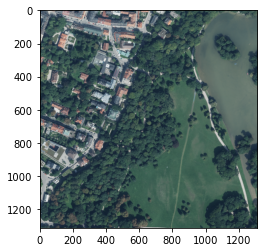

In [5]:
# read and display sample images

img_shape = None
img_transform = None
img_crs = None

with rasterio.open(SAMPLE_TILE_PATH) as src:
  print('input image')
  print(src.meta)
  img_shape = src.shape
  img_transform = src.transform
  img_crs = src.crs
  rasterio.plot.show(src.read())


X = pixel_features.PixelFeaturesBuilder(**MODEL_PARAMS_FEATURES).build_features_from_filepath(SAMPLE_TILE_PATH)

In [4]:
## use pre-trained classifier
trained_clf_c1 = joblib.load(CLASSIFIER_DETECTREE_C1_DUMP)
trained_clf_c2 = joblib.load(CLASSIFIER_DETECTREE_C2_DUMP)

In [6]:
# save image
def save(data, label, img_transform, img_crs, dtype, astype):
  p = EXAMPLE_OUTPUT_DIR.joinpath(label + SAMPLE_TILE_PATH.name)
  with rasterio.open(p, 'w', driver='GTiff',
                  width=data.shape[1], height=data.shape[0],
                  count=1, dtype=dtype, nodata=0,
                  transform=img_transform, crs=img_crs) as dst:
    dst.write(data.astype(astype), 1)
  print(label, p)
  rasterio.plot.show(data)

c1.no_refined. temp/example/opendata_luftbild_dop60_1312/detectree_r1/inference/c1.no_refined.1290091.025782968_6132926.158789683_1290874.505322890_6133709.638329607.tiff


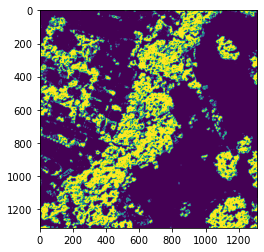

c2.no_refined. temp/example/opendata_luftbild_dop60_1312/detectree_r1/inference/c2.no_refined.1290091.025782968_6132926.158789683_1290874.505322890_6133709.638329607.tiff


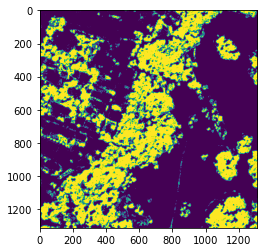

In [7]:
# predict class directly and assign final output tree/none-tree values (no post refinement)
c1_y_pred      = trained_clf_c1.predict(X).reshape(img_shape)
c2_y_pred      = trained_clf_c2.predict(X).reshape(img_shape)

# check: binary classes in the current detectree version https://github.com/martibosch/detectree/issues/10
assert np.array_equal(np.unique(c1_y_pred), np.array([0, 1]))

c1_data_no_refined = (c1_y_pred > 0) * MODEL_PARAMS['tree_val']
c2_data_no_refined = (c2_y_pred > 0) * MODEL_PARAMS['tree_val']

save(c1_data_no_refined, label="c1.no_refined.", img_transform=img_transform, img_crs=img_crs, dtype=rasterio.uint8, astype=np.uint8)
save(c2_data_no_refined, label="c2.no_refined.", img_transform=img_transform, img_crs=img_crs, dtype=rasterio.uint8, astype=np.uint8)

c1.proba. temp/example/opendata_luftbild_dop60_1312/detectree_r1/inference/c1.proba.1290091.025782968_6132926.158789683_1290874.505322890_6133709.638329607.tiff


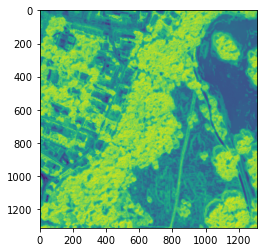

c2.proba. temp/example/opendata_luftbild_dop60_1312/detectree_r1/inference/c2.proba.1290091.025782968_6132926.158789683_1290874.505322890_6133709.638329607.tiff


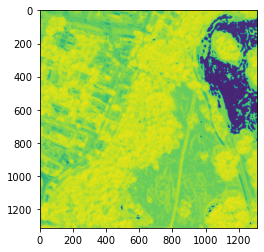

In [8]:
# predict raw probability of all pixel w.r.t tree and none-tree
c1_p_nontree,      c1_p_tree      = np.hsplit(trained_clf_c1.predict_proba(X), 2)
c2_p_nontree,      c2_p_tree      = np.hsplit(trained_clf_c2.predict_proba(X), 2)

c1_P_tree         = c1_p_tree.reshape(img_shape)
c1_P_nontree      = c1_p_nontree.reshape(img_shape)
c2_P_tree         = c2_p_tree.reshape(img_shape)
c2_P_nontree      = c2_p_nontree.reshape(img_shape)

save(c1_P_tree,      label="c1.proba.",      img_transform=img_transform, img_crs=img_crs, dtype=rasterio.float32, astype=np.float32)
save(c2_P_tree,      label="c2.proba.",      img_transform=img_transform, img_crs=img_crs, dtype=rasterio.float32, astype=np.float32)

c1.refined.50. temp/example/opendata_luftbild_dop60_1312/detectree_r1/inference/c1.refined.50.1290091.025782968_6132926.158789683_1290874.505322890_6133709.638329607.tiff


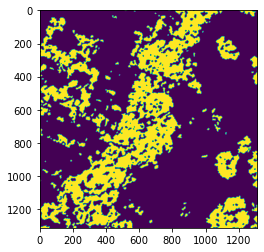

c1.refined.10. temp/example/opendata_luftbild_dop60_1312/detectree_r1/inference/c1.refined.10.1290091.025782968_6132926.158789683_1290874.505322890_6133709.638329607.tiff


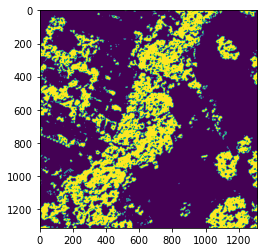

c1.refined.100. temp/example/opendata_luftbild_dop60_1312/detectree_r1/inference/c1.refined.100.1290091.025782968_6132926.158789683_1290874.505322890_6133709.638329607.tiff


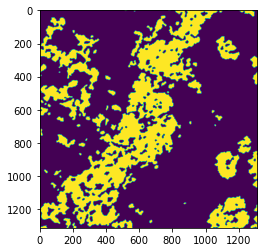

c2.refined.10. temp/example/opendata_luftbild_dop60_1312/detectree_r1/inference/c2.refined.10.1290091.025782968_6132926.158789683_1290874.505322890_6133709.638329607.tiff


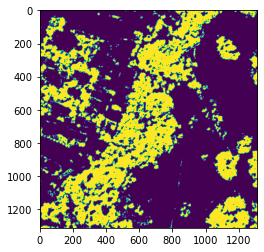

c2.refined.40. temp/example/opendata_luftbild_dop60_1312/detectree_r1/inference/c2.refined.40.1290091.025782968_6132926.158789683_1290874.505322890_6133709.638329607.tiff


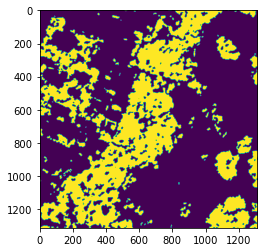

c2.refined.50. temp/example/opendata_luftbild_dop60_1312/detectree_r1/inference/c2.refined.50.1290091.025782968_6132926.158789683_1290874.505322890_6133709.638329607.tiff


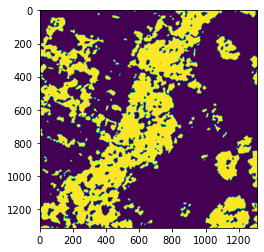

c2.refined.60. temp/example/opendata_luftbild_dop60_1312/detectree_r1/inference/c2.refined.60.1290091.025782968_6132926.158789683_1290874.505322890_6133709.638329607.tiff


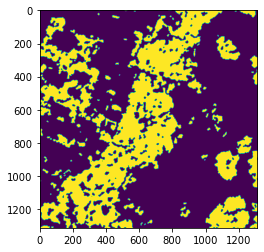

c2.refined.100. temp/example/opendata_luftbild_dop60_1312/detectree_r1/inference/c2.refined.100.1290091.025782968_6132926.158789683_1290874.505322890_6133709.638329607.tiff


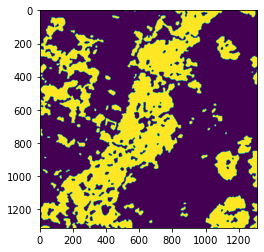

In [9]:
# refinement with min-cut/max-flow based on raw pixel probability
def refine(img_shape, P_nontree, P_tree, weight):
  g = mf.Graph[int]()
  node_ids = g.add_grid_nodes(img_shape)
  D_tree = (MODEL_PARAMS['refine_int_rescale'] * np.log(P_nontree)).astype(int)
  D_nontree = (MODEL_PARAMS['refine_int_rescale'] * np.log(P_tree)).astype(int)
  MOORE_NEIGHBORHOOD_ARR = np.array([[0, 0, 0], [0, 0, 1], [1, 1, 1]])
  g.add_grid_edges(node_ids, weight,
                    structure=MOORE_NEIGHBORHOOD_ARR)
  g.add_grid_tedges(node_ids, D_tree, D_nontree)
  g.maxflow()
  data_refined = np.full(img_shape, MODEL_PARAMS['nontree_val'])
  data_refined[g.get_grid_segments(node_ids)] = MODEL_PARAMS['tree_val']
  return data_refined

c1_data_refined_10  = refine(img_shape=img_shape, P_nontree=c1_P_nontree, P_tree=c1_P_tree, weight=10)
c1_data_refined_50  = refine(img_shape=img_shape, P_nontree=c1_P_nontree, P_tree=c1_P_tree, weight=50)
c1_data_refined_100 = refine(img_shape=img_shape, P_nontree=c1_P_nontree, P_tree=c1_P_tree, weight=100)

c2_data_refined_10  = refine(img_shape=img_shape, P_nontree=c2_P_nontree, P_tree=c2_P_tree, weight=10)
c2_data_refined_40  = refine(img_shape=img_shape, P_nontree=c2_P_nontree, P_tree=c2_P_tree, weight=40)
c2_data_refined_50  = refine(img_shape=img_shape, P_nontree=c2_P_nontree, P_tree=c2_P_tree, weight=50)
c2_data_refined_60  = refine(img_shape=img_shape, P_nontree=c2_P_nontree, P_tree=c2_P_tree, weight=60)
c2_data_refined_100 = refine(img_shape=img_shape, P_nontree=c2_P_nontree, P_tree=c2_P_tree, weight=100)

save(c1_data_refined_50, label="c1.refined.50.", img_transform=img_transform, img_crs=img_crs  , dtype=rasterio.uint8, astype=np.uint8)
save(c1_data_refined_10, label="c1.refined.10.", img_transform=img_transform, img_crs=img_crs  , dtype=rasterio.uint8, astype=np.uint8)
save(c1_data_refined_100, label="c1.refined.100.", img_transform=img_transform, img_crs=img_crs, dtype=rasterio.uint8, astype=np.uint8)

save(c2_data_refined_10, label="c2.refined.10.", img_transform=img_transform, img_crs=img_crs  , dtype=rasterio.uint8, astype=np.uint8)
save(c2_data_refined_40, label="c2.refined.40.", img_transform=img_transform, img_crs=img_crs  , dtype=rasterio.uint8, astype=np.uint8)
save(c2_data_refined_50, label="c2.refined.50.", img_transform=img_transform, img_crs=img_crs  , dtype=rasterio.uint8, astype=np.uint8)
save(c2_data_refined_60, label="c2.refined.60.", img_transform=img_transform, img_crs=img_crs  , dtype=rasterio.uint8, astype=np.uint8)
save(c2_data_refined_100, label="c2.refined.100.", img_transform=img_transform, img_crs=img_crs, dtype=rasterio.uint8, astype=np.uint8)

c1.morphology. temp/example/opendata_luftbild_dop60_1312/detectree_r1/inference/c1.morphology.1290091.025782968_6132926.158789683_1290874.505322890_6133709.638329607.tiff


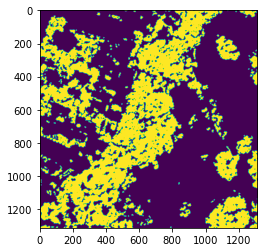

c2.morphology. temp/example/opendata_luftbild_dop60_1312/detectree_r1/inference/c2.morphology.1290091.025782968_6132926.158789683_1290874.505322890_6133709.638329607.tiff


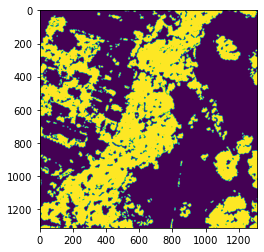

In [12]:
### morphology method
def morphology(data_no_refined):
  labels = data_no_refined > 0 # turn to boolean type ndarray
  min_size = 8 # TODO: depending on tile resolution
  data_no_refined_nosmall = skimage.morphology.remove_small_objects(labels, min_size=min_size).astype(int) * 255
  struct = skimage.morphology.disk(2)
  data_no_refined_nosmall_dilation = scipy.ndimage.morphology.binary_dilation(
        data_no_refined_nosmall, structure=struct) * MODEL_PARAMS['tree_val']
  return data_no_refined_nosmall_dilation

#generic_data_morphology = morphology(data_no_refined=generic_data_no_refined)
c1_data_morphology      = morphology(data_no_refined=c1_data_no_refined)
c2_data_morphology      = morphology(data_no_refined=c2_data_no_refined)

save(c1_data_morphology, label="c1.morphology.", img_transform=img_transform, img_crs=img_crs, dtype=rasterio.uint8, astype=np.uint8)
save(c2_data_morphology, label="c2.morphology.", img_transform=img_transform, img_crs=img_crs, dtype=rasterio.uint8, astype=np.uint8)
